# 00. 분석준비

In [1]:
# 준비 

# colab 드라이브 연결하기 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!apt-get install -y fonts-nanum > /dev/null
!fc-cache -fv > /dev/null
!rm -rf ~/.cache/matplotlib > /dev/null

In [1]:
# 패키지 불러오기
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic')

import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objs as go 
import plotly.express as px



# 01. 데이터 준비

In [2]:
df1 = pd.read_csv("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/T20_2019_1백만.1.csv", encoding = "euc-kr")
df2 = pd.read_csv("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/T20_2019_1백만.2.csv", encoding = "euc-kr")
df3 = pd.read_csv("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/T20_2019_1백만.3.csv", encoding = "euc-kr")

In [3]:
# 데이터 합치기 
df = pd.concat([df1,df2,df3])
del df1, df2, df3

## 1) 타겟 컬럼 생성 : 입원 여부 

In [5]:
# 서식코드 확인 
df['서식코드'].unique()

array([3, 2, 8])

In [4]:
# 서식코드를 입원여부로 변환
# 1이면 입원 O, 0이면 입원 X 
df.loc[(df['서식코드']==2), '서식코드'] = 1 
df.loc[(df['서식코드']==3), '서식코드'] = 0
df.loc[(df['서식코드']==8), '서식코드'] = 0

In [7]:
# 변환 확인 
df['서식코드'].unique()

array([0, 1])

In [5]:
# 컬럼명 변경 
df.rename(columns = {'서식코드' : '입원여부'}, inplace= True)

## 2) 시도명 컬럼 추가 

In [9]:
# 시도 데이터 불러오기 
df_sido = pd.read_csv("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/sido.txt", sep = "|")
df_sido.head(2)

,시도코드,시도명
0,11,서울시
1,26,부산시


In [ ]:
# 시도명 컬럼 추가 
df_sido.columns = ['시도코드', '시도명']
df = pd.merge(df, df_sido, how = 'left', on = '시도코드')

## 3) 연령대코드 연령대로 변환 

In [6]:
# 0, 10, 20 ,...,80 대로 변경 
count = 0
age = 80
for i in range(18,0, -1) : 
  if count == 0 : 
    df.loc[(df['연령대코드']==i), '연령대코드'] = str(age) 
    count += 1 
  elif count ==1 : 
    df.loc[(df['연령대코드']==i), '연령대코드'] = str(age) 
    count = 0 
    age -= 10

## 4) 진료과목명 컬럼 추가 

In [12]:
# 진료과목코드 데이터 불러오기 
df_subject = pd.read_excel("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/컬럼정보_코드.xls")
df_subject.head(2)

,코드구분,설명,코드,명칭
0,진료과목코드,분석차원_진료과목코드,0,일반의
1,진료과목코드,분석차원_진료과목코드,1,내과


In [13]:
# 안쓰는 데이터 컬럼 제거 
df_subject.drop(['코드구분', '설명'], axis = 1 , inplace = True)
df_subject.columns = ['진료과목코드', '진료과목']

In [14]:
# 컬럼 합치기 
df = pd.merge(df, df_subject, how = 'left', on = '진료과목코드')

## 5) 주상병코드, 부상병코드 컬럼 변환 

In [7]:
# 앞의 한 글자만 추출 
df['주상병코드'] = df['주상병코드'].str[:1]
df['부상병코드'] = df['부상병코드'].str[:1]

In [17]:
df.columns

Index(['기준년도', '가입자 일련번호', '진료내역일련번호', '성별코드', '연령대코드', '시도코드', '요양개시일자',
       '입원여부', '진료과목코드', '주상병코드', '부상병코드', '요양일수', '입내원일수', '심결가산율',
       '심결요양급여비용총액', '심결본인부담금', '심결보험자부담금', '총처방일수', '데이터 기준일자', '시도명',
       '진료과목'],
      dtype='object')

In [8]:
# 사용하지 않는 컬럼 제거 
df.drop(['기준년도', '가입자 일련번호', '진료내역일련번호','요양일수', '입내원일수', '심결요양급여비용총액','심결본인부담금', '심결보험자부담금', '총처방일수', '데이터 기준일자'], axis =1, inplace = True)

In [ ]:
df.head(2)

In [17]:
df.to_csv("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/df2.csv", index = False)
df = pd.read_csv("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/df2.csv")
df.head(2)

,성별코드,연령대코드,시도코드,요양개시일자,입원여부,진료과목코드,주상병코드,부상병코드,심결가산율
0,2,50,46,20191104,0,5,M,M,0.25
1,2,50,46,20190806,0,1,E,N,0.25


# 02. 데이터 탐색 및 시각화 (EDA)

## 1) 입원비율 

In [21]:
# 입원 비율 (모든 방문 횟수에 대해서)
df['입원여부'].mean()

0.021547622254539548

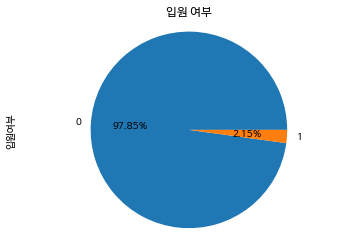

In [3]:
df_temp = df['입원여부'].value_counts()
df_temp.plot.pie(autopct='%.2f%%')
plt.title('입원 여부')
plt.axis('equal')
plt.show()

## 2) 연령별 입원 비율 

In [5]:
# 연령대로 count 
df_0 = df.groupby(['연령대코드']).count()
df_1 = df.groupby(['연령대코드', '입원여부']).count()

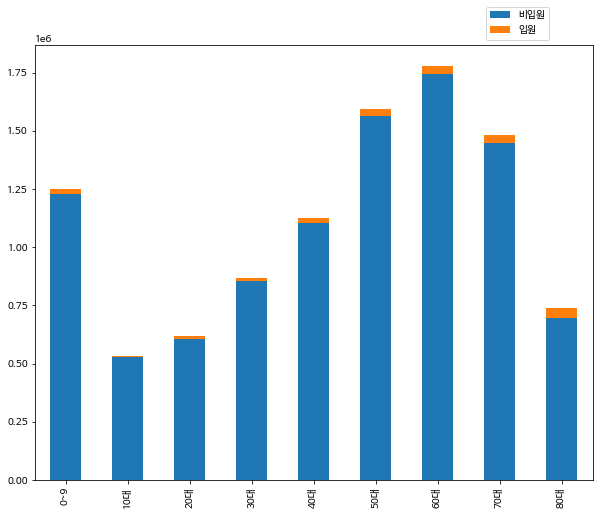

In [6]:
age = ['0~9','10대','20대','30대','40대','50대','60대','70대','80대']
data={
    '비입원' : [1230624, 528143, 608161, 853802, 1105645, 1564150, 1743195, 1449059, 695962],
    '입원' : [19643, 5762, 9845, 15738, 18390, 31328, 36297, 35026, 43195]
}
df_temp=pd.DataFrame(data,index=age)

df_temp.plot(kind="bar",stacked=True,figsize=(10,8))
plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.show()

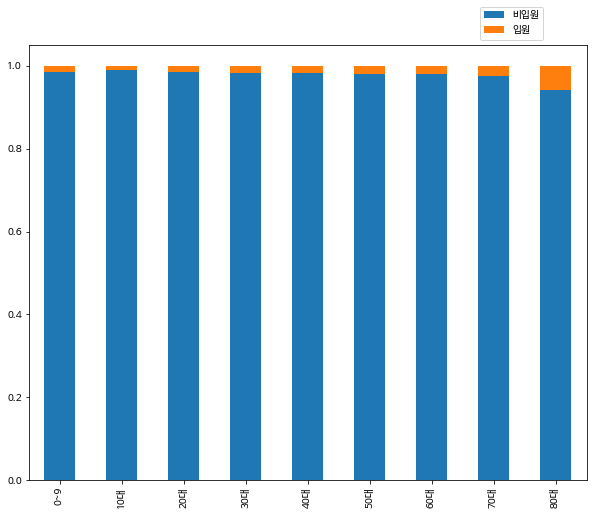

In [7]:
age = ['0~9','10대','20대','30대','40대','50대','60대','70대','80대']
data={
    '비입원' : [1230624/1250267, 528143/533905, 608161/618006, 853802/869540,\
             1105645/1124035, 1564150/1595478, 1743195/1779492, 1449059/1484085, 695962/739157],
    '입원' : [19643/1250267, 5762/533905, 9845/618006, 15738/869540,\
            18390/1124035, 31328/1595478, 36297/1779492, 35026/1484085, 43195/739157]
}
df_temp=pd.DataFrame(data,index=age)

df_temp.plot(kind="bar",stacked=True,figsize=(10,8))
plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.show()

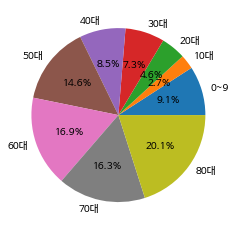

In [9]:
# 연령별 입원환자 비율
ratio = [19643, 5762, 9845, 15738, 18390, 31328, 36297, 35026, 43195]
labels = ['0~9','10대','20대','30대','40대','50대','60대','70대','80대']

plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

In [11]:
## 진료 횟수별로
df_age1 = df['연령대코드'].value_counts().sort_index()
df_age1

0     1650030
10     705121
20     812876
30    1144721
40    1479872
50    2104654
60    2352891
70    1955731
80     972449
Name: 연령대코드, dtype: int64

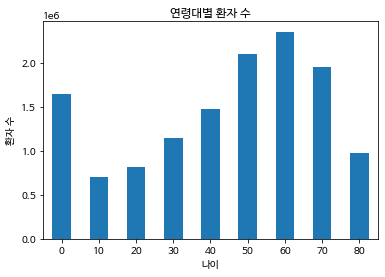

In [12]:
df_age1.plot(kind='bar', rot=0)
plt.title("연령대별 환자 수")
plt.xlabel("나이")
plt.ylabel("환자 수")
plt.show()

## 3) 시도 별 입원 비율 

In [13]:
# 시도별 입원 여부 회수 데이터프레임 생성 
df_sido = pd.crosstab(index = df['시도명'], columns= df['입원여부'] )
df_sido.reset_index(inplace = True)
df_sido.columns = ['시도명','입원 X', "입원 O"]
df_sido.head()

,시도명,입원 X,입원 O
0,강원도,356466,7928
1,경기도,3143574,57946
2,경상남도,839227,24848
3,경상북도,690849,17174
4,광주시,337543,11748


In [14]:
# 비율 추가 
df_sido['비율O'] = df_sido['입원 O'] / (df_sido['입원 O'] + df_sido['입원 X'])
df_sido['비율X'] = df_sido['입원 X'] / (df_sido['입원 O'] + df_sido['입원 X'])

In [16]:
# 시각화
fig = go.Figure()

fig.add_trace(go.Bar(x = df_sido['시도명'], y = df_sido['비율X'], name = '입원 X'))
fig.add_trace(go.Bar(x = df_sido['시도명'], y = df_sido['비율O'], name = '입원 O'))

fig.update_layout(title = '시도별 입원 여부 비율', xaxis_title = '시도명', yaxis_title = '비율', barmode="stack" )

fig.show()
fig.write_html("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/sido.html")

## 4) 진료과목 별 입원 비율 

In [7]:
# 진료과목 별 방문수 (입원환자, 비입원환자)

# 전체 빈도수
df_dsbjt = pd.DataFrame(df['진료과목'].value_counts()).reset_index()
df_dsbjt = df_dsbjt.sort_values(by = 'index')
df_dsbjt.columns = ['진료과목', '빈도수(전체환자)']
df_dsbjt.reset_index(drop = True, inplace = True)

# 입원환자 빈도수
df_dsbjt_sp1 = pd.DataFrame(df[df['입원여부'] == 1]['진료과목'].value_counts()).reset_index()
df_dsbjt_sp1 = df_dsbjt_sp1.sort_values(by = 'index')
df_dsbjt_sp1.columns = ['진료과목', '빈도수(입원환자)']
df_dsbjt_sp1.reset_index(drop = True, inplace = True)

# 비입원환자 빈도수
df_dsbjt_sp2 = pd.DataFrame(df[df['입원여부'] == 0]['진료과목'].value_counts()).reset_index()
df_dsbjt_sp2 = df_dsbjt_sp2.sort_values(by = 'index')
df_dsbjt_sp2.columns = ['진료과목', '빈도수(비입원환자)']
df_dsbjt_sp2.reset_index(drop = True, inplace = True)

df_dsbjt = pd.merge(df_dsbjt, df_dsbjt_sp2, how = 'outer', on = '진료과목')
df_dsbjt = pd.merge(df_dsbjt, df_dsbjt_sp1, how = 'outer', on = '진료과목')
df_dsbjt.head(2)

,진료과목,빈도수(전체환자),빈도수(비입원환자),빈도수(입원환자)
0,가정의학과,379753,361533.0,18220.0
1,결핵과,1086,1017.0,69.0


In [8]:
# 진료과목 별 방문수 비율 (입원환자, 비입원환자)

y1, y2, y3 = df_dsbjt['빈도수(전체환자)'].sum(), df_dsbjt['빈도수(입원환자)'].sum(), df_dsbjt['빈도수(비입원환자)'].sum()

df_dsbjt['비율(전체환자)'] =  df_dsbjt['빈도수(전체환자)'].apply(lambda x: round((x / y1) * 100, 1))
df_dsbjt['비율(입원환자)'] =  df_dsbjt['빈도수(입원환자)'].apply(lambda x: round((x / y2) * 100, 1))
df_dsbjt['비율(비입원환자)'] =  df_dsbjt['빈도수(비입원환자)'].apply(lambda x: round((x / y3) * 100, 1))
df_dsbjt.head(2)

,진료과목,빈도수(전체환자),빈도수(비입원환자),빈도수(입원환자),비율(전체환자),비율(입원환자),비율(비입원환자)
0,가정의학과,379753,361533.0,18220.0,2.9,6.4,2.8
1,결핵과,1086,1017.0,69.0,0.0,0.0,0.0


In [10]:
df_dsbjt.sort_values(by = '비율(전체환자)', ascending = False).head(10)

,진료과목,빈도수(전체환자),빈도수(비입원환자),빈도수(입원환자),비율(전체환자),비율(입원환자),비율(비입원환자)
3,내과,4387959,4319462.0,68497.0,33.3,24.1,33.5
22,정형외과,2140561,2100772.0,39789.0,16.2,14.0,16.3
18,이비인후과,1466074,1460814.0,5260.0,11.1,1.9,11.3
13,안과,874455,868336.0,6119.0,6.6,2.2,6.7
10,소아청소년과,751840,730986.0,20854.0,5.7,7.3,5.7
27,피부과,600112,599709.0,403.0,4.6,0.1,4.7
16,외과,417561,393159.0,24402.0,3.2,8.6,3.0
8,산부인과,375779,361396.0,14383.0,2.9,5.1,2.8
0,가정의학과,379753,361533.0,18220.0,2.9,6.4,2.8
21,정신건강의학과,332942,323406.0,9536.0,2.5,3.4,2.5


In [11]:
df_dsbjt.sort_values(by = '비율(입원환자)', ascending = False).head(10)

,진료과목,빈도수(전체환자),빈도수(비입원환자),빈도수(입원환자),비율(전체환자),비율(입원환자),비율(비입원환자)
3,내과,4387959,4319462.0,68497.0,33.3,24.1,33.5
22,정형외과,2140561,2100772.0,39789.0,16.2,14.0,16.3
16,외과,417561,393159.0,24402.0,3.2,8.6,3.0
17,응급의학과,122222,101335.0,20887.0,0.9,7.4,0.8
10,소아청소년과,751840,730986.0,20854.0,5.7,7.3,5.7
12,신경외과,265289,246843.0,18446.0,2.0,6.5,1.9
0,가정의학과,379753,361533.0,18220.0,2.9,6.4,2.8
20,재활의학과,161725,146418.0,15307.0,1.2,5.4,1.1
8,산부인과,375779,361396.0,14383.0,2.9,5.1,2.8
11,신경과,230131,219417.0,10714.0,1.7,3.8,1.7


In [12]:
df_dsbjt.sort_values(by = '비율(비입원환자)', ascending = False).head(10)

,진료과목,빈도수(전체환자),빈도수(비입원환자),빈도수(입원환자),비율(전체환자),비율(입원환자),비율(비입원환자)
3,내과,4387959,4319462.0,68497.0,33.3,24.1,33.5
22,정형외과,2140561,2100772.0,39789.0,16.2,14.0,16.3
18,이비인후과,1466074,1460814.0,5260.0,11.1,1.9,11.3
13,안과,874455,868336.0,6119.0,6.6,2.2,6.7
10,소아청소년과,751840,730986.0,20854.0,5.7,7.3,5.7
27,피부과,600112,599709.0,403.0,4.6,0.1,4.7
16,외과,417561,393159.0,24402.0,3.2,8.6,3.0
0,가정의학과,379753,361533.0,18220.0,2.9,6.4,2.8
8,산부인과,375779,361396.0,14383.0,2.9,5.1,2.8
21,정신건강의학과,332942,323406.0,9536.0,2.5,3.4,2.5


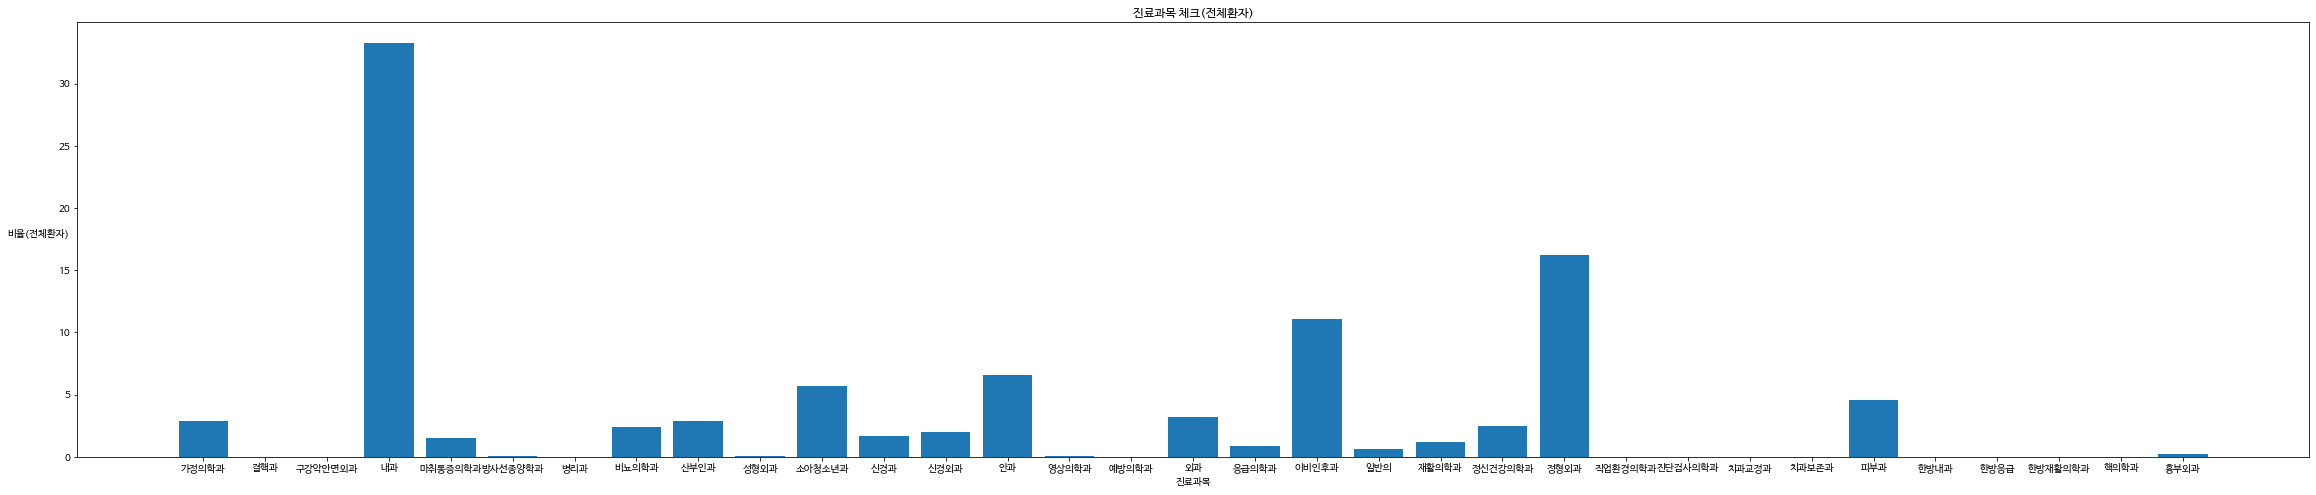

In [14]:
# 진료과목 별 전체 환자 수 
plt.figure(figsize = (40, 8))
plt.title('진료과목 체크(전체환자)')
plt.bar(df_dsbjt['진료과목'], df_dsbjt['비율(전체환자)'])
plt.xlabel('진료과목')
plt.ylabel('비율(전체환자)', rotation = 0, labelpad = 20)
plt.show()

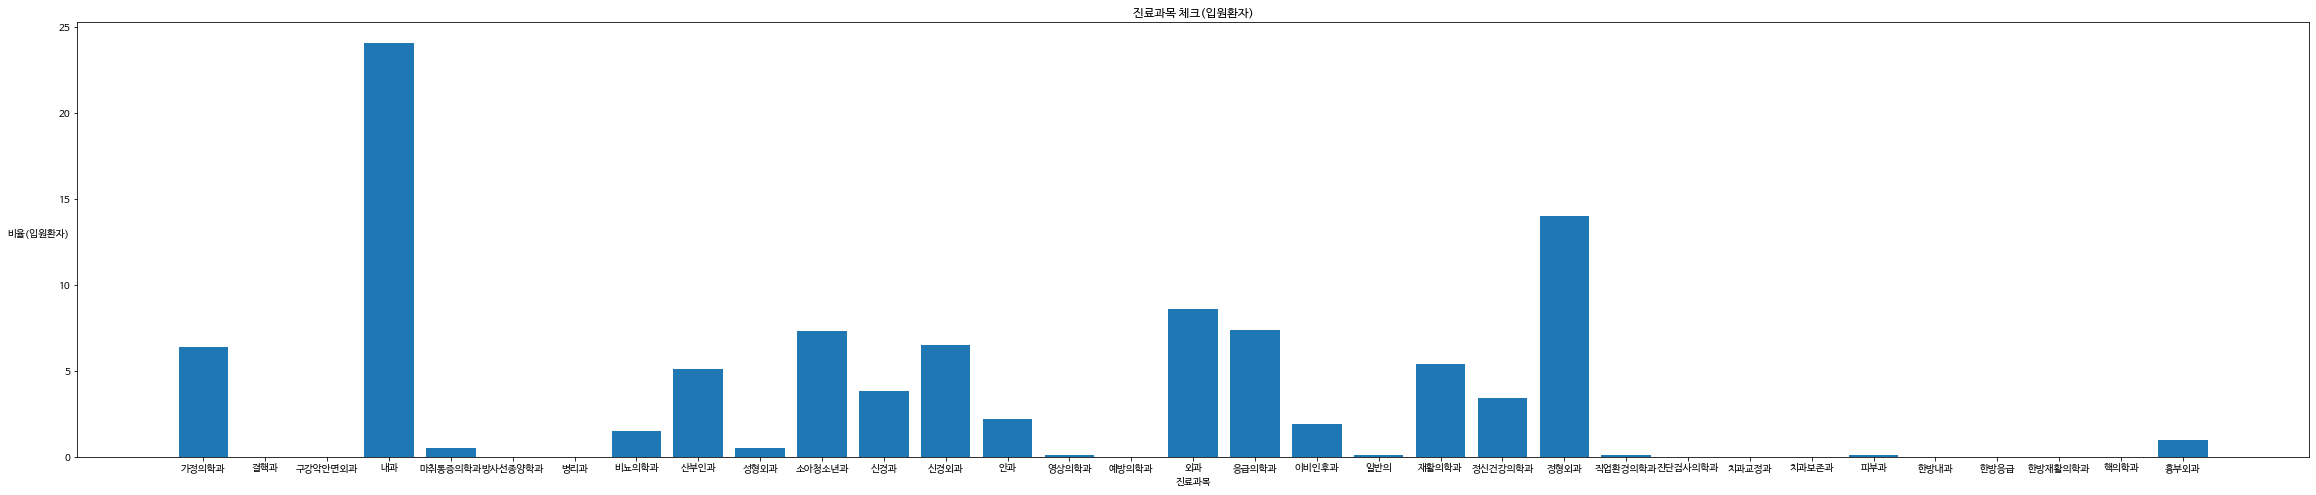

In [15]:
# 전체 입원환자 중 해당 진료과목이 차지하는 비율 
plt.figure(figsize = (40, 8))
plt.title('진료과목 체크(입원환자)')
plt.bar(df_dsbjt['진료과목'], df_dsbjt['비율(입원환자)'])
plt.xlabel('진료과목')
plt.ylabel('비율(입원환자)', rotation = 0, labelpad = 20)
plt.show()

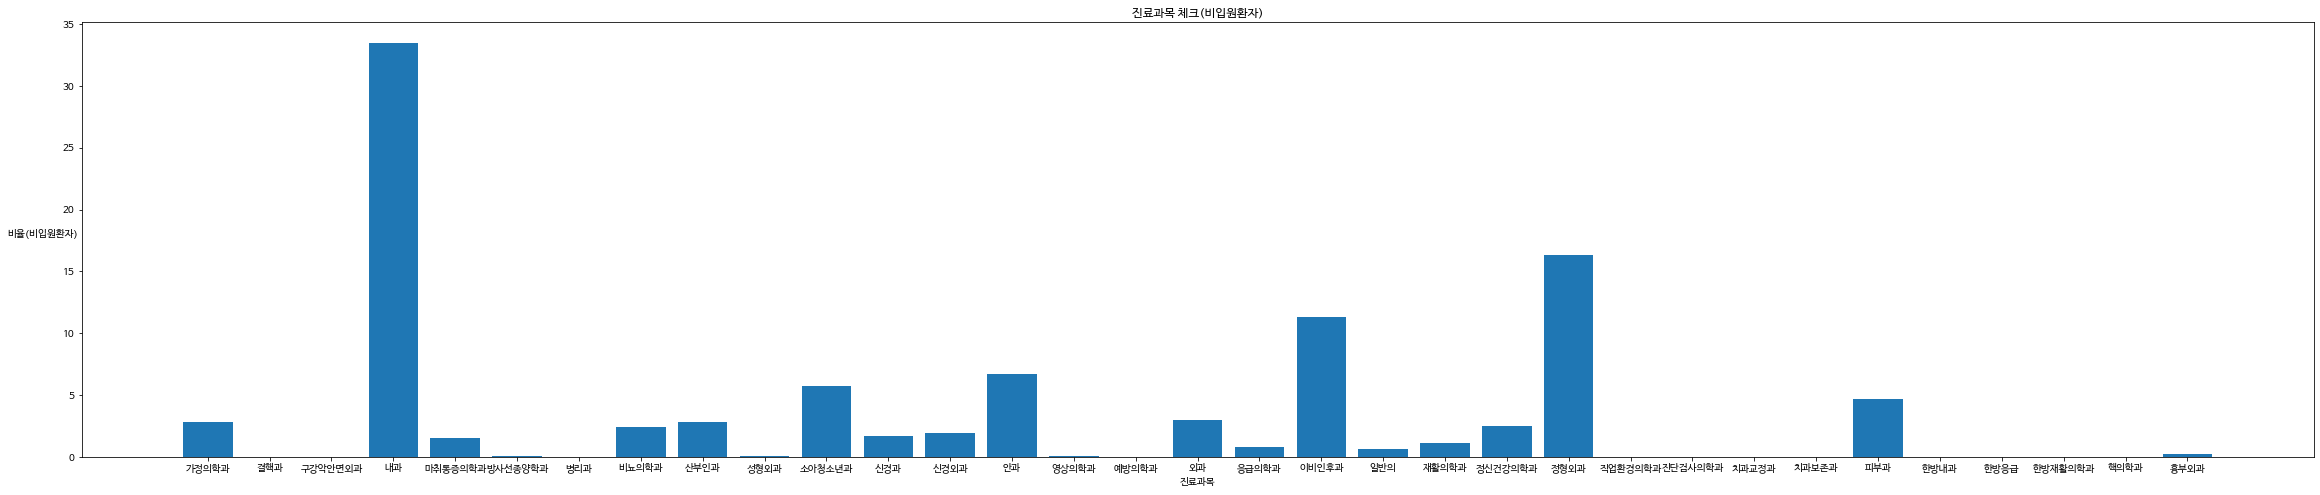

In [17]:
# 전체 비입원환자 중 해당 진료과목이 차지하는 비율 
plt.figure(figsize = (40, 8))
plt.title('진료과목 체크(비입원환자)')
plt.bar(df_dsbjt['진료과목'], df_dsbjt['비율(비입원환자)'])
plt.xlabel('진료과목')
plt.ylabel('비율(비입원환자)', rotation = 0, labelpad = 20)
plt.show()

In [19]:
# 진료과목 별 입원 비율 
df_type = pd.crosstab(index = df['진료과목'], columns= df['입원여부'] )
df_type.reset_index(inplace = True)
df_type.columns = ['진료과목','입원 X', "입원 O"]

df_type['비율O'] = df_type['입원 O'] / (df_type['입원 O'] + df_type['입원 X'])
df_type['비율X'] = df_type['입원 X'] / (df_type['입원 O'] + df_type['입원 X'])

df_type.head(2)

,진료과목,입원 X,입원 O,비율O,비율X
0,가정의학과,361533,18220,0.047979,0.952021
1,결핵과,1017,69,0.063536,0.936464


In [21]:
fig = go.Figure()

fig.add_trace(go.Bar(x = df_type['진료과목'], y = df_type['비율X'], name = '입원 X'))
fig.add_trace(go.Bar(x = df_type['진료과목'], y = df_type['비율O'], name = '입원 O'))

fig.update_layout(title = '진료과목별 입원 여부 비율', xaxis_title = '진료과목명', yaxis_title = '비율', barmode="stack" )
fig.write_html("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/type.html")
fig.show()

## 5) 상병코드 별 입원 비율 
- 주상병코드 
- 부상병코드

In [25]:
# 주상병코드 별 입원 여부 회수 계산
df_ju = df.groupby(['주상병코드','입원여부']).count()
df_ju = df_ju[['성별코드']]
df_ju.columns = ['회수']
df_ju.reset_index(inplace = True)


# 주상병코드 별 입원 비율 
df_sum = pd.DataFrame(df.groupby(['주상병코드']).count()['성별코드'])
df_sum.reset_index(inplace = True)
df_ju = pd.merge(df_ju, df_sum, how = 'outer', on = ['주상병코드'])
df_ju['비율'] = df_ju['회수']/df_ju['성별코드']
df_ju.drop('성별코드', axis = 1, inplace = True)
df_ju.head(2)

,주상병코드,입원여부,회수,비율
0,A,0,191940,0.948465
1,A,1,10429,0.051535


In [27]:
fig = go.Figure()

fig.add_trace(go.Bar(x = df_ju[df_ju['입원여부']==0]['주상병코드'], y = df_ju[df_ju['입원여부']==0]['비율'], name = '입원 X'))
fig.add_trace(go.Bar(x = df_ju[df_ju['입원여부']==1]['주상병코드'], y = df_ju[df_ju['입원여부']==1]['비율'], name = '입원 O'))

fig.update_layout(title = '주상병코드 별 입원 여부 비율', xaxis_title = '주상병코드', yaxis_title = '비율', barmode="stack" )

fig.write_html("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/ju.html")
fig.show()

In [29]:
# 부상병코드 별 입원 여부 회수 계산
df_bu = df.groupby(['부상병코드','입원여부']).count()
df_bu = df_bu[['성별코드']]
df_bu.columns = ['회수']
df_bu.reset_index(inplace = True)


# 부상병코드 별 입원 비율 
df_sum = pd.DataFrame(df.groupby(['부상병코드']).count()['성별코드'])
df_sum.reset_index(inplace = True)
df_bu = pd.merge(df_bu, df_sum, how = 'outer', on = ['부상병코드'])
df_bu['비율'] = df_bu['회수']/df_bu['성별코드']
df_bu.drop('성별코드', axis = 1, inplace = True)
df_bu.head(2)

,부상병코드,입원여부,회수,비율
0,A,0,159286,0.971938
1,A,1,4599,0.028062


In [30]:
fig = go.Figure()

fig.add_trace(go.Bar(x = df_bu[df_bu['입원여부']==0]['부상병코드'], y = df_bu[df_bu['입원여부']==0]['비율'], name = '입원 X'))
fig.add_trace(go.Bar(x = df_bu[df_bu['입원여부']==1]['부상병코드'], y = df_bu[df_bu['입원여부']==1]['비율'], name = '입원 O'))

fig.update_layout(title = '부상병코드 별 입원 여부 비율', xaxis_title = '부상병코드', yaxis_title = '비율', barmode="stack" )

fig.write_html("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/bu.html")
fig.show()

## 6) 요양개시일자(요일) 별 입원 비율

In [31]:
df_day = pd.crosstab(index = df['요양개시일자'], columns = df['입원여부'])
df_day.reset_index(inplace = True)
df_day.columns = ['요양개시일자','입원 X', "입원 O"]
df_day.head(2)

,요양개시일자,입원 X,입원 O
0,20190101,3934,7198
1,20190102,52798,1009


In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = df_day['요양개시일자'], y = df_day['입원 O'], name = '입원 O'))

fig.update_layout(title = '일자별 입원 수', xaxis_title = '날짜', yaxis_title = '회수', barmode="stack" )
fig.update_xaxes(type='category')

fig.show()

In [33]:
# 계절별 
df_day['요양개시일자'] = df_day['요양개시일자']//100

fig = go.Figure()

fig.add_trace(go.Scatter(x = df_day['요양개시일자'], y = df_day['입원 O'], name = '입원 O'))

fig.update_layout(title = '일자별 입원 수', xaxis_title = '날짜', yaxis_title = '회수', barmode="stack" )
fig.update_xaxes(type='category')

fig.show()

In [18]:
# 요일로 데이터 변환 

# 함수 생성 및 데이터 변환
import datetime 
def weekday(day) : 
  days = ['월','화','수','목','금','토','일']
  y = day//10000
  m = (day%10000)//100
  d = day%100
  a = datetime.date(y,m,d).weekday()
  return days[a] 

df['요일'] = df['요양개시일자'].apply(weekday)

In [44]:
df_week = pd.crosstab(index = df['요일'], columns = df['입원여부'])
df_week.reset_index(inplace = True)
df_week.columns = ['요양개시요일','입원 X', "입원 O"]

df_week['num'] = [4,3,2,0,6,5,1]
df_week.sort_values(by = 'num', inplace = True, ascending= True)
df_week.reset_index(drop = True, inplace = True)
df_week.drop('num', axis = 1, inplace = True)
df_week.head(2)


,요양개시요일,입원 X,입원 O
0,월,2753919,56586
1,화,2219747,49496


In [45]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = df_week['요양개시요일'], y = df_week['입원 O'], name = '입원 O'))

fig.update_layout(title = '요일별 입원 수', xaxis_title = '요일', yaxis_title = '회수')
fig.update_xaxes(type='category')

fig.write_html("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/week.html")
fig.show()

# 03. 상관성 확인

In [19]:
df.columns

Index(['성별코드', '연령대코드', '시도코드', '요양개시일자', '입원여부', '진료과목코드', '주상병코드', '부상병코드',
       '심결가산율', '요일'],
      dtype='object')

In [20]:
df = df[['성별코드', '연령대코드', '시도코드','진료과목코드', '주상병코드', '부상병코드','심결가산율','요일', '입원여부']]
df.head(2)

,성별코드,연령대코드,시도코드,진료과목코드,주상병코드,부상병코드,심결가산율,요일,입원여부
0,2,50,46,5,M,M,0.25,월,0
1,2,50,46,1,E,N,0.25,화,0


## 1) 문자열 변수를 숫자형 변수로 변환

In [21]:
# 주, 부상병코드 알파벳 인덱싱 
eng_list = ['A','B','C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
code_dict = dict(zip(eng_list, [i for i in range(len(eng_list))]))
df['주상병코드'] = df['주상병코드'].apply(lambda x: code_dict[x])
df['부상병코드'] = df['부상병코드'].apply(lambda x: code_dict[x])

# 심결가산율 카테고리화 및 인덱싱
rate_list = pd.DataFrame(df['심결가산율'].value_counts()).index
rate_list = sorted(rate_list)
rate_dict = dict(zip(rate_list, [i for i in range(len(rate_list))]))
df['심결가산율'] = df['심결가산율'].apply(lambda x: rate_dict[x])

# 요일 숫자로 변환
def weekday(day) : 
  days = ['월','화','수','목','금','토','일']
  return days.index(day)
df['요일'] = df['요일'].apply(weekday)

df.head(2)

,성별코드,연령대코드,시도코드,진료과목코드,주상병코드,부상병코드,심결가산율,요일,입원여부
0,2,50,46,5,12,12,3,0,0
1,2,50,46,1,4,13,3,1,0


## 2) 범주형으로 변환

In [23]:
for i in df.columns : 
  df[i] = df[i].astype("category")
df.dtypes

성별코드      category
연령대코드     category
시도코드      category
진료과목코드    category
주상병코드     category
부상병코드     category
심결가산율     category
요일        category
입원여부      category
dtype: object

## 3) 상관성 확인 

In [26]:
# 상관성 확인
from scipy.stats import chi2_contingency
 
for i in df.columns[:-1] : 
  df_cross = pd.crosstab(index=df[i],columns=df['입원여부'])
  ChiSqResult = chi2_contingency(df_cross)
  print(f'{i} : The P-Value of the ChiSq Test is:', ChiSqResult[1])

성별코드 : The P-Value of the ChiSq Test is: 1.4459695826147777e-15
연령대코드 : The P-Value of the ChiSq Test is: 0.0
시도코드 : The P-Value of the ChiSq Test is: 0.0
진료과목코드 : The P-Value of the ChiSq Test is: 0.0
주상병코드 : The P-Value of the ChiSq Test is: 0.0
부상병코드 : The P-Value of the ChiSq Test is: 0.0
심결가산율 : The P-Value of the ChiSq Test is: 0.0
요일 : The P-Value of the ChiSq Test is: 0.0


# 04. Pre-processing

In [29]:
# target 비율 맞추기 
# undersampling 하기
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import warnings

warnings.filterwarnings("ignore")

X = df.drop('입원여부', axis = 1)
y = df['입원여부']

# # X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)
print("Before undersampling: ", Counter(y))

undersample = RandomUnderSampler(sampling_strategy='majority')

# # fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)
print("After undersampling: ", Counter(y_under))

Before undersampling:  Counter({0: 12894383, 1: 283962})
After undersampling:  Counter({0: 283962, 1: 283962})


In [30]:
df_under = pd.DataFrame(X_under , columns= X.columns)
X = X_under 
y = y_under
df_under.head(2)

,성별코드,연령대코드,시도코드,진료과목코드,주상병코드,부상병코드,심결가산율,요일
0,1,60,26,14,13,17,1,0
1,2,70,41,1,4,8,1,0


In [31]:
df_under['입원여부'] = y_under
df_under.head(2)

,성별코드,연령대코드,시도코드,진료과목코드,주상병코드,부상병코드,심결가산율,요일,입원여부
0,1,60,26,14,13,17,1,0,0
1,2,70,41,1,4,8,1,0,0


In [32]:
# 상관성 재확인 
for i in df_under.columns[:-1] : 
  df_cross = pd.crosstab(index=df_under[i],columns=df_under['입원여부'])
  ChiSqResult = chi2_contingency(df_cross)
  print(f'{i} : The P-Value of the ChiSq Test is:', ChiSqResult[1])

성별코드 : The P-Value of the ChiSq Test is: 5.692018846391625e-07
연령대코드 : The P-Value of the ChiSq Test is: 0.0
시도코드 : The P-Value of the ChiSq Test is: 0.0
진료과목코드 : The P-Value of the ChiSq Test is: 0.0
주상병코드 : The P-Value of the ChiSq Test is: 0.0
부상병코드 : The P-Value of the ChiSq Test is: 0.0
심결가산율 : The P-Value of the ChiSq Test is: 0.0
요일 : The P-Value of the ChiSq Test is: 0.0


In [33]:
# 데이터 타입 변경 
for i in df.columns : 
  df_under[i] = df[i].astype("category")
df_under.dtypes

성별코드      category
연령대코드     category
시도코드      category
진료과목코드    category
주상병코드     category
부상병코드     category
심결가산율     category
요일        category
입원여부      category
dtype: object

In [34]:
# 데이터셋 분리 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state = 42)

# 05. 모델 생성

## 1) Decision Tree

In [36]:
# 모델 생성 
from sklearn.tree import DecisionTreeClassifier
tree2 = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=6, min_samples_leaf=200)
tree2.fit(X_train,y_train)

print(tree2.score(X_test,y_test))

0.848507898944225


In [ ]:
# decision tree 그리기 
from sklearn.tree import export_graphviz

export_graphviz(
    tree2, # 학습한 모형
    out_file = 'tree2.dot', # .dot 파일 저장 위치
    feature_names = list(df_under.columns[:-1]), # 사용한 변수 이름
    class_names = ['입원함', '입원안함'], # 예측할 타겟 클래스 이름
)
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("tree2.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [38]:
# depth 변화 
score = []
for i in range(3,20) : 
  tree2 = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=i, min_samples_leaf=200)
  tree2.fit(X_train,y_train)
  score.append(tree2.score(X_test,y_test))
print(score)

[0.8456061022249456, 0.8456061022249456, 0.8472471668744409, 0.848507898944225, 0.8487684971932864, 0.8509518879286665, 0.8520154105126743, 0.8533324881498229, 0.8547552137257802, 0.8550298983666829, 0.8561779393017376, 0.857614751269536, 0.858002127045168, 0.8581148181798973, 0.8581852501391031, 0.8582627252942295, 0.8584881075636881]


In [39]:
# depth 변화 시각화
import plotly.graph_objs as go 
import plotly.express as px

fig = go.Figure()
x = [i for i in range(3,20)]
fig.add_trace(go.Scatter(x = x, y = score))
fig.show()

In [41]:
# depth 11로 모델 생성 
tree2 = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=11, min_samples_leaf=200)
tree2.fit(X_train,y_train)
tree2.score(X_test,y_test)

0.8547552137257802

In [42]:
# 혼동 행렬 
y_pred_train =tree2.predict(X_train)

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

accuracy = metrics.accuracy_score(y_train, y_pred_train)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_train,y_pred_train)
print('Confusion Matrix: \n', cm)

Accuracy: 0.86
Confusion Matrix: 
 [[170089  42882]
 [ 17845 195127]]


In [43]:
# kflod 모델 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kfold = KFold(n_splits = 6, shuffle = True, random_state = 100)

print("cross validation score : {}".format(cross_val_score(tree2, X_under, y_under, cv = kfold)))

cross validation score : [0.85753375 0.85676252 0.85629767 0.85695269 0.85575887 0.85735415]


## 2) Naive Bayes 

In [50]:
from sklearn.naive_bayes import MultinomialNB

# 모델 생성
nb = MultinomialNB()

# 모델 훈련
nb.fit(X_train, y_train)

# 모델 테스트
nb.score(X_test, y_test)

0.610645086314366

In [51]:
# 혼동행렬
confusion_matrix(y_test, labels)

array([[42713, 28278],
       [27003, 43987]])

In [46]:
kfold = KFold(n_splits = 6, shuffle = True, random_state = 100)

print("cross validation score : {}".format(cross_val_score(nb, X_under, y_under, cv = kfold)))

cross validation score : [0.60706362 0.60717983 0.60659877 0.60994781 0.6089019  0.60605997]


## 3) Logistic Regression 

In [47]:
from sklearn.linear_model import LogisticRegression

# 모델 생성 
logi = LogisticRegression()

# 모델 훈련
logi.fit(X_train, y_train)

# 모델 테스트 
logi.score(X_test,y_test)

0.7964868538748142

In [48]:
# 회귀식 계수 확인
logi.coef_

array([[ 0.07974193,  0.01122561,  0.01090589,  0.0399227 , -0.0111966 ,
         0.0338738 ,  1.3924999 ,  0.07159081]])

In [49]:
# 혼동행렬
y_pred_train =logi.predict(X_train)
cm=confusion_matrix(y_train,y_pred_train)
print('Confusion Matrix: \n', cm)

Confusion Matrix: 
 [[173565  39406]
 [ 47490 165482]]


In [52]:
kfold = KFold(n_splits = 6, shuffle = True, random_state = 100)

print("cross validation score : {}".format(cross_val_score(logi, X_under, y_under, cv = kfold)))

cross validation score : [0.79581423 0.79559237 0.79696579 0.79757855 0.79552898 0.79509582]


## 4) Knn

In [53]:
from sklearn.neighbors import KNeighborsClassifier

# 모델 생성 
knn = KNeighborsClassifier(n_neighbors = 3)

# 모델 훈련
knn.fit(X_train, y_train)

# 모델 테스트 
knn.score(X_test,y_test)

0.8239130587895563

In [54]:
# 혼동 행렬
y_pred_train =knn.predict(X_train)
cm=confusion_matrix(y_train,y_pred_train)
print('Confusion Matrix: \n', cm)

Confusion Matrix: 
 [[186997  25974]
 [ 21510 191462]]


In [55]:
# 거리 weight 없이, k값 변화 시, accuracy 변화 확인 
k_range = range(5,20)             
k_score = []                       

for k in k_range :
	knn = KNeighborsClassifier(n_neighbors = k)
	knn.fit(X_train, y_train)
	k_score.append(knn.score(X_test,y_test))    

fig = go.Figure()
x = [i for i in range(5,20)]
fig.add_trace(go.Scatter(x = x, y = k_score))
fig.show()

In [56]:
# 거리 weight 있이, k값 변화 시, accuracy 변화 확인 

k_range = range(5,20)              
k_score = []                       

for k in k_range :
	knn = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
	knn.fit(X_train, y_train)
	k_score.append(knn.score(X_test,y_test))   
 
fig = go.Figure()
x = [i for i in range(5,20)]
fig.add_trace(go.Scatter(x = x, y = k_score))
fig.show()

In [58]:
knn = KNeighborsClassifier(n_neighbors = 7, weights = 'distance')

kfold = KFold(n_splits = 6, shuffle = True, random_state = 100)
print("cross validation score : {}".format(cross_val_score(knn, X_under, y_under, cv = kfold)))

cross validation score : [0.82997021 0.82973778 0.82877639 0.82876582 0.82972722 0.83060409]


## 06. 모델 저장

In [59]:
import joblib

joblib.dump(tree2, '/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/tree_model.pkl')
joblib.dump(nb, '/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/nb_model.pkl')
joblib.dump(logi, '/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/logi_model.pkl')
joblib.dump(knn, '/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/knn_model.pkl')

['/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/knn_model.pkl']

In [60]:
loaded_model = joblib.load('/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/tree_model.pkl')

In [68]:
df.columns

Index(['성별코드', '연령대코드', '시도코드', '진료과목코드', '주상병코드', '부상병코드', '심결가산율', '요일',
       '입원여부'],
      dtype='object')

In [67]:
# loaded_model.predict([['성별코드', '연령대코드', '시도코드', '진료과목코드', '주상병코드', '부상병코드', '심결가산율', '요일']])[0]
loaded_model.predict([[2,50,46,5,12,1,3,4]])[0]

1